# Exploratory Data Analysis
 
 Following scraping data, we clean and explore the relationships between variables

## Cleaning the data

In [602]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from dateutil import parser as ps
import datetime as dt
from workalendar.usa import UnitedStates
from workalendar.asia import SouthKorea, China, Japan
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.discrete.discrete_model as smd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

In [633]:
# Read in the file
df=pd.read_pickle('./FullVGChartzDatabase.zip',compression = 'zip')
num_rows_original = df.shape[0]

In [634]:
# Turn all N/A's into np.nan values so pandas can operate with them easily
df_obj = df.select_dtypes('object')
df[df.columns] = df_obj.apply(lambda x: x.str.strip())
df=df.replace('N/A',np.nan)

In [635]:
# Merge columns total sales and total shipped because they describe the same thing but one is \
# for games no longer in production
df['total_shipped'].fillna(df['total_sales'],inplace = True)
df.dropna(subset=['total_shipped'],inplace = True)
df.drop(columns = ['total_sales','last_update','position'],inplace = True)

In [636]:
# Function to remove the 'm' and convert sales data column into floats
def drop_m(df,column_name):
    if column_name not in df.columns:
        return 'Cannot find column in dataframe!'
    df[column_name].loc[df[column_name].notnull()] = df[column_name].loc[df[column_name].notnull()].str[:-1].astype(float)
    return True

drop_m(df,'total_shipped')
drop_m(df,'pal_sales')
drop_m(df,'na_sales')
drop_m(df,'japan_sales')
drop_m(df,'other_sales');

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Outliers: 
Drop Wii sports because it was packaged with the Wii console in some locations and there aren't pubic concrete numbers as to how many were sold vs bundled with consoles. 

In [637]:

df=df.sort_values(by = 'total_shipped',ascending = False).drop(index = 0)


In [638]:
# Convert date column to date time objects
datetime_column = df['release_date'].loc[df['release_date'].notnull()].apply(lambda item: ps.parse(str(item)))
df['release_date'] = datetime_column

In [639]:
df_sorted_by_date = df.sort_values(by = ['release_date']).reset_index()
#plt.scatter(df_sorted_by_date['release_date'].tolist(),np.log(df_sorted_by_date['total_shipped'].tolist())

In [640]:
 # df_sorted_by_date.loc[df_sorted_by_date['release_date'].astype(str)
df_sorted_by_date = df_sorted_by_date.loc[df_sorted_by_date['release_date'].astype(str) != 'NaT']

# How many points did cut out due to no release date?
df.shape[0] - df_sorted_by_date.shape[0]

522

In [641]:
# Drop bogus values with release date of 2020
df_sorted_by_date = df_sorted_by_date.loc[df_sorted_by_date['release_date'].apply(lambda element: element.year < 2020)]
df=df_sorted_by_date

# Filter for games with 100,000 sales or more (minimum recorded)
print("Number of games with < 100,000 shipped copies:",  df.loc[df['total_shipped'] < .09].shape[0])
df=df.loc[df['total_shipped'] > .09].sort_values(by = ['total_shipped'])

df['average_rating'] = df[['vgchart_score', 'critic_score','user_score']].astype(float).mean(axis=1)

# Filter out games with no ratings
print("Number of games with no ratings:",df.loc[df['average_rating'].isnull()].shape[0])
df = df.loc[df['average_rating'].notnull()]


Number of games with < 100,000 shipped copies: 8042
Number of games with no ratings: 8201


In [642]:
# After selecting games with 100,000+ sales and have ratings, how many rows left
df.sort_values(by = ['average_rating'],ascending = False).shape[0]

4000

In [643]:
df.drop(columns = ['vgchart_score','critic_score','user_score',\
                   'na_sales','pal_sales','japan_sales','other_sales',\
                   'developer'], inplace = True)

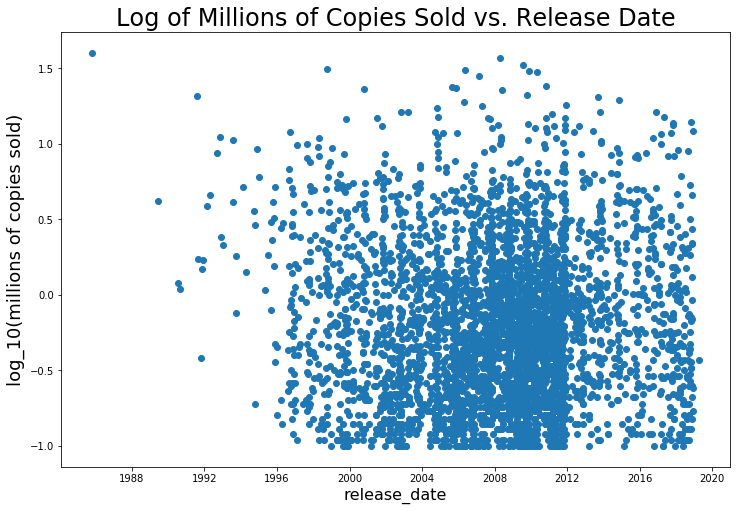

In [647]:
# A log transformation helps normalize the data

plt.figure(figsize=(12,8))
myplot = plt.scatter(df['release_date'],df['total_shipped'].apply(np.log10))
plt.title('Log of Millions of Copies Sold vs. Release Date', fontsize = 24)
plt.ylabel('log_10(millions of copies sold)', fontsize=18);
plt.xlabel('release_date', fontsize=16);

In [615]:
df['release_year'] = df['release_date'].apply(lambda element: element.year)

# Things to be aware of:

- Some games were sold in packages (duck hunt, super mario)

- Some games were packaged with console ( wii sports)

- Calculate holidays based on US and East Asia (China, SK, Japan) will be about 75% of all consumers based off newZoo market research 2018

In [616]:
df_sorted_by_date.shape

(20688, 14)

In [617]:
# Set the range for days before holidays to look at
day_range = 4

def make_set_of_near_holidays(country,day_range):
    # Takes workalendar Country() object and makes a set of holidays between 1983 and 2018. Note:\
    # does not work on China, because China has insufficient data (holiday data only to 2018)
    set_of_near_holidays=set()
    # Number of days to include before holidays + 1 
    for year in range(1983,2019):
        for day_tuple in country.holidays(year):
            set_of_near_holidays.add(day_tuple[0]);
            for day_count in range(1,day_range):
                set_of_near_holidays.add(day_tuple[0] - dt.timedelta(days =day_count))
            #set_of_near_holidays.append(day_tuple[0]) - dt.timedelta(days = 1);
    # Save unique holidays
    return (set_of_near_holidays)


In [618]:
# These three countries capture ~75% of market according to Newzoo market data for 2018. Therefore we'll look
# at market data for just these.

us_holidays = make_set_of_near_holidays(UnitedStates(),day_range)
south_korea_holidays = make_set_of_near_holidays(SouthKorea(),day_range);
japan_holidays = make_set_of_near_holidays(Japan(),day_range)
# workalendar package only includes 2018 data for China, so it needs its own code. We'll approximate\
# the past years' holiday dates as close to 2018 dates.
china_holidays = set()
for date_tuple in China().holidays(2018):
    china_holidays.add(date_tuple[0])
    for day_count in range(1,day_range):
        china_holidays.add(date_tuple[0] - dt.timedelta(days = day_count))


/anaconda3/lib/python3.7/site-packages/workalendar/asia/china.py:63: UserWarning: Support 2018, 2019 currently, need update every year.
  warnings.warn("Support 2018, 2019 currently, need update every year.")


In [619]:
# Convert from pandas Timestamp to python datetime
df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())

In [620]:
df['near_us_holiday'] = df['release_date'].apply(lambda x: x in us_holidays)
df['near_sk_holiday'] = df['release_date'].apply(lambda x: x in south_korea_holidays)
df['near_jp_holiday'] = df['release_date'].apply(lambda x: x in japan_holidays)

In [621]:
# Compare all China holidays to 2018 because that's the only dataset available
def convert_day_to_2018(input_datetime):
    if(input_datetime.month == 2 and input_datetime.day == 29):
        day_corrected = input_datetime.day - 1
    else:
        day_corrected = input_datetime.day
        
    return dt.date(year = 2018, month = input_datetime.month, day = day_corrected)
df['near_cn_holiday'] = df['release_date'].apply(lambda x: convert_day_to_2018(x) in china_holidays)

In [622]:
df['years_since_release'] = dt.datetime.now().year - df['release_year']

In [623]:
df = df.drop(columns='index')

In [624]:
# Grabbed from 2018 top revenue publishers, mergers like activision blizzard are split to identify games released 
# independently.
def in_top_10_publishers(publisher_name):
    publisher_name = publisher_name.lower()
    top_publishers = ['sony','microsoft','nintendo',\
                  'activision','blizzard','bandai','namco','square','enix'\
                 'ubisoft','electronic arts','ea sports']
    for top_pub in top_publishers:
        if top_pub in publisher_name:
            return True
    return False
df['top_10_publisher'] = df['publisher'].apply(lambda x: in_top_10_publishers(x))

In [625]:
df.rename(columns={'total_shipped':'total_shipped_in_mil'}, inplace=True)


In [626]:
df['years_since_release'] = (dt.datetime.now().toordinal()-\
                             df['release_date'].apply(lambda x: dt.date.toordinal(x)))/365

In [627]:
df_features = df.drop(columns = ['release_date','release_year','game','console','publisher'])

In [628]:
df_features.head()

,total_shipped_in_mil,average_rating,near_us_holiday,near_sk_holiday,near_jp_holiday,near_cn_holiday,years_since_release,top_10_publisher
12973,0.1,8.0,False,False,True,True,8.975342,False
13019,0.1,5.7,False,True,False,False,8.917808,False
13103,0.1,3.5,False,False,False,False,8.879452,False
13123,0.1,6.8,False,False,False,False,8.860274,False
9572,0.1,8.2,False,False,False,False,10.852055,False


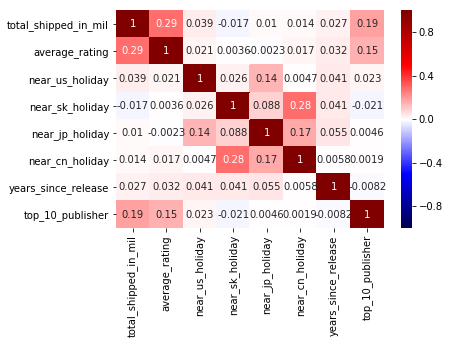

In [439]:

sns.heatmap(df_features.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

In [440]:
def patsy_string_from_df(df_features):
    patsy_string = df_features.columns[0] + " ~ "
    for title in df_features.columns[1:]:
        patsy_string += title + " + "
    #remove last plus and spaces from string
    patsy_string=patsy_string[:-3]
    return patsy_string


In [441]:
def sm_OLS_model(df_features):
    y, X = patsy.dmatrices(patsy_string_from_df(df_features), data=df_features, return_type="dataframe")
    model = sm.OLS(y, X)
    # Fit your model to your training set
    fit = model.fit()

    # Print summary statistics of the model's performance
    return fit

In [442]:
df_features.sort_values(by = 'total_shipped_in_mil',ascending= False).head()

,total_shipped_in_mil,average_rating,near_us_holiday,near_sk_holiday,near_jp_holiday,near_cn_holiday,years_since_release,top_10_publisher
146,40.24,9.100000,False,False,False,False,33.515068,True
9437,37.14,8.666667,False,False,True,True,10.975342,True
11648,33.09,8.533333,False,False,False,False,9.728767,True
1478,31.38,9.400000,False,True,False,True,20.556164,True
6929,30.80,8.600000,False,False,False,False,12.928767,True


In [443]:
# It looks like release date proximity to holidays doesn't really have an impact on total sales. Let's drop those
df_features.drop(columns = ['near_sk_holiday','near_jp_holiday','near_cn_holiday'],inplace = True)
patsy_string_from_df(df_features)


'total_shipped_in_mil ~ average_rating + near_us_holiday + years_since_release + top_10_publisher'

In [444]:
fit1=sm_OLS_model(df_features)
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     total_shipped_in_mil   R-squared:                       0.104
Model:                              OLS   Adj. R-squared:                  0.104
Method:                   Least Squares   F-statistic:                     116.5
Date:                  Tue, 16 Apr 2019   Prob (F-statistic):           4.13e-94
Time:                          14:58:23   Log-Likelihood:                -9356.9
No. Observations:                  4000   AIC:                         1.872e+04
Df Residuals:                      3995   BIC:                         1.876e+04
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.9512      0.237    -12.458      0.000      -3.416      -2.487
near_us_holiday[T.True]      0.2846      0.147      1.939      0.053      -0.003       0.572
top_10_publisher[T.True]     0.7878      0.081      9.752      0.000       0.629       0.946
average_rating               0.5178      0.030     17.342      0.000       0.459       0.576
years_since_release          0.0097      0.008      1.215      0.224      -0.006       0.025
==============================================================================
Omnibus:                     4744.119   Durbin-Watson:                   0.185
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           605472.382
Skew:                           6.236   Prob(JB):                         0.00
Kurtosis:                      61.969   Cond. No.                         84.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

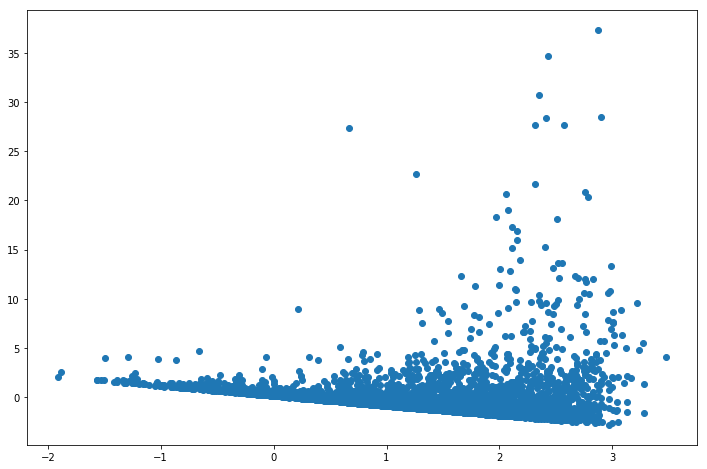

In [629]:
plt.figure(figsize=(12,8))
plt.scatter(fit1.predict(), fit1.resid);

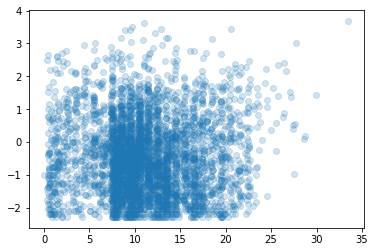

In [631]:
plt.scatter(df_features['years_since_release'],
            df_features['total_shipped_in_mil'].apply(lambda x:np.log(x)),alpha = .2)

In [447]:
df_features['total_shipped_in_mil_log'] = df_features['total_shipped_in_mil'].apply(lambda x:np.log(x))
df_features_with_predicted=df_features

In [448]:
df_features = df_features.drop(columns = 'total_shipped_in_mil')

In [449]:
df_features.columns

Index(['average_rating', 'near_us_holiday', 'years_since_release',
       'top_10_publisher', 'total_shipped_in_mil_log'],
      dtype='object')

In [450]:
scaler = StandardScaler()
scaled_vals = scaler.fit_transform(df_features[['total_shipped_in_mil_log','average_rating','years_since_release']])
scaled_features = pd.DataFrame(scaled_vals,columns = ['total_shipped_in_mil_log_scaled',
                                                      'rating_scaled',
                                                      'years_since_release_scaled'])
scaled_features['top_10_publisher'] = df_features.reset_index()['top_10_publisher']
scaled_features['near_us_holiday'] = df_features.reset_index()['near_us_holiday']

In [451]:
df_features.reset_index().head()

,index,average_rating,near_us_holiday,years_since_release,top_10_publisher,total_shipped_in_mil_log
0,12973,8.0,False,8.975342,False,-2.302585
1,13019,5.7,False,8.917808,False,-2.302585
2,13103,3.5,False,8.879452,False,-2.302585
3,13123,6.8,False,8.860274,False,-2.302585
4,9572,8.2,False,10.852055,False,-2.302585


In [452]:
scaled_features.head()

,total_shipped_in_mil_log_scaled,rating_scaled,years_since_release_scaled,top_10_publisher,near_us_holiday
0,-1.579836,0.441942,-0.446277,False,False
1,-1.579836,-1.266883,-0.457832,False,False
2,-1.579836,-2.901411,-0.465534,False,False
3,-1.579836,-0.449619,-0.469386,False,False
4,-1.579836,0.590535,-0.069389,False,False


In [453]:
scaled_features.columns
scaled_features.corr()
#sns.heatmap(scaled_features.corr(),annot = True)



,total_shipped_in_mil_log_scaled,rating_scaled,years_since_release_scaled,top_10_publisher,near_us_holiday
total_shipped_in_mil_log_scaled,1.000000,0.421552,0.000585,0.268752,0.051874
rating_scaled,0.421552,1.000000,0.032168,0.149279,0.020890
years_since_release_scaled,0.000585,0.032168,1.000000,-0.008238,0.040865
top_10_publisher,0.268752,0.149279,-0.008238,1.000000,0.022581
near_us_holiday,0.051874,0.020890,0.040865,0.022581,1.000000


In [454]:
scaled_model = sm_OLS_model(scaled_features)

In [455]:
scaled_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     total_shipped_in_mil_log_scaled   R-squared:                       0.223
Model:                                         OLS   Adj. R-squared:                  0.222
Method:                              Least Squares   F-statistic:                     286.1
Date:                             Tue, 16 Apr 2019   Prob (F-statistic):          1.28e-216
Time:                                     14:58:40   Log-Likelihood:                -5171.9
No. Observations:                             4000   AIC:                         1.035e+04
Df Residuals:                                 3995   BIC:                         1.039e+04
Df Model:                                        4                                         
Covariance Type:                         nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.2003      0.019    -10.403      0.000      -0.238      -0.163
top_10_publisher[T.True]       0.4214      0.028     14.852      0.000       0.366       0.477
near_us_holiday[T.True]        0.1457      0.052      2.827      0.005       0.045       0.247
rating_scaled                  0.3898      0.014     27.614      0.000       0.362       0.418
years_since_release_scaled    -0.0118      0.014     -0.848      0.397      -0.039       0.016
==============================================================================
Omnibus:                      100.203   Durbin-Watson:                   0.446
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              107.038
Skew:                           0.397   Prob(JB):                     5.71e-24
Kurtosis:                       2.886   Cond. No.                         4.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Wrong distribution? 
It appears the data is bounded. This makes sense, because there are a lot of observations around 0.01 mil sales. I'll pivot and use a Poisson distribution instead.


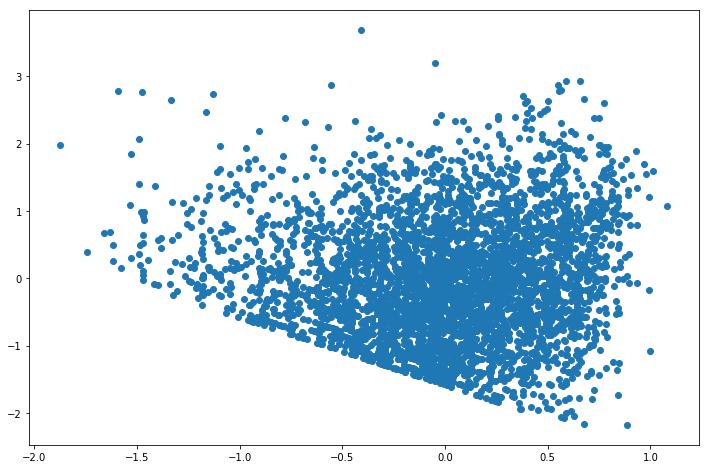

In [456]:
plt.figure(figsize=(12,8))
plt.scatter(scaled_model.predict(), scaled_model.resid);

Text(0.5, 0, 'Z score')

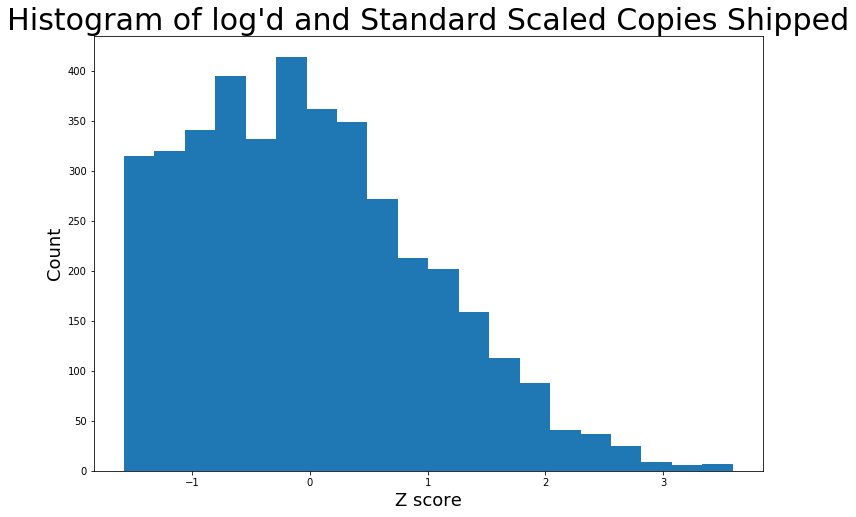

In [658]:
plt.figure(figsize=(12,8))
plt.hist(scaled_features['total_shipped_in_mil_log_scaled'],bins = 20)
plt.title("Histogram of log'd and Standard Scaled Copies Shipped",fontsize = 30)
plt.ylabel('Count',fontsize = 18)
plt.xlabel('Z score',fontsize = 18)

In [525]:
df_features_with_predicted['total_shipped_in_thousands'] = df_features_with_predicted['total_shipped_in_mil'] * 1000

In [528]:
df_features_with_predicted=df_features_with_predicted.drop(columns = ['total_shipped_in_mil','total_shipped_in_mil_log'])

In [530]:

df_features_with_predicted.head()

,average_rating,near_us_holiday,years_since_release,top_10_publisher,total_shipped_in_thousands
12973,8.0,False,8.975342,False,100.0
13019,5.7,False,8.917808,False,100.0
13103,3.5,False,8.879452,False,100.0
13123,6.8,False,8.860274,False,100.0
9572,8.2,False,10.852055,False,100.0


In [566]:
df_features_with_predicted.head()

,average_rating,near_us_holiday,years_since_release,top_10_publisher,total_shipped_in_thousands
12973,8.0,False,8.975342,False,100.0
13019,5.7,False,8.917808,False,100.0
13103,3.5,False,8.879452,False,100.0
13123,6.8,False,8.860274,False,100.0
9572,8.2,False,10.852055,False,100.0


In [567]:
y = df_features_with_predicted['total_shipped_in_thousands'].values
X = df_features.iloc[:,:-1].values


In [570]:
# Cast variables to correct datatypes
y = y.astype(int)
X = X.astype(float)

In [571]:
# Fit GLM in statsmodels using Poisson link function
poisson_model = sm.GLM(y, X, family = sm.families.Poisson())
poisson_result = poisson_model.fit()
poisson_result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 4000
Model:                            GLM   Df Residuals:                     3996
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.6422e+06
Date:                Tue, 16 Apr 2019   Deviance:                   7.2513e+06
Time:                        18:44:37   Pearson chi2:                 2.15e+07
No. Iterations:                     6   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8457      0.000   6105.813      0.000       0.845       0.846
x2             0.1553      0.001    108.589      0.000       0.153       0.158
x3             0.0071   7.76e-05     91.421      0.000       0.007       0.007
x4             0.5954      0.001    649.373      0.000       0.594       0.597
==============================================================================
"""

In [560]:
poisson_model.fit


<bound method GLM.predict of <statsmodels.genmod.generalized_linear_model.GLM object at 0x1c38567d30>>

In [561]:
test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Poisson Regression Results                                
===========================================================================================
Dep. Variable:     total_shipped_in_mil_log_scaled   No. Observations:                 4000
Model:                                     Poisson   Df Residuals:                     3995
Method:                                        MLE   Df Model:                            4
Date:                             Tue, 16 Apr 2019   Pseudo R-squ.:                     nan
Time:                                     18:42:35   Log-Likelihood:                    nan
converged:                                    True   LL-Null:                           nan
                                                     LLR p-value:                       nan
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                         nan        nan        nan        nan         nan         nan
top_10_publisher[T.True]          nan        nan        nan        nan         nan         nan
near_us_holiday[T.True]           nan        nan        nan        nan         nan         nan
rating_scaled                     nan        nan        nan        nan         nan         nan
years_since_release_scaled        nan        nan        nan        nan         nan         nan
==============================================================================================
"""

# Workflow - Project 2


## Compare features

- pair plots
- bar charts
- group by time

## Read online sources

- what do experts say will increase target variable

## Hypothesis what linear model may tell you

- what are expectations

## Fit basic model before feature manipulation

- see if statistics are stastically sig
- normally distributed residuals
- check null hypothesis, p value
- this is baseline model
- standardize features

## Try polynomial fitting , LR_2, LR_custom feature extraction

- Compare different iterations

## Regularization

- Polynomial to 3rd or 4th degree / transforms to try to normally distribute
- increase lambda slowly to see when results give low error
- that is ideal level of complexity

## Other things:

- Start **TOO COMPLEX** before grid search
- Need to be 'to the right' of optimal point

### Grid search
- for regularization
- use log scale for lambda .0001 to 100,000
- for alpha and complement > 0 to 1
- for each  alpha and lambda, cross validate 
- sk learn will give you best model parameters
    - choose best model based on stuff like meansquared error on out of smaple data
- after finding model, you are **done**

### Pipeline
- for this project, don't need to mess with it

# Error Statistics to Include

# Root Mean Squared Error
- average miss between model and test set in units of predicted variable
- can compare to total of outcome variable for percentage 
- squaring of error terms means it penalizes 

# Mean absolute error
- less sensitive to outliers
